# Sampling with Delphi

In [1]:
import os
import pickle
import torch
import torch.nn.functional
from model import DelphiConfig, Delphi
from tqdm import tqdm
import pandas as pd
import numpy as np
import textwrap

import matplotlib.pyplot as plt
%config InlineBackend.figure_format='retina'

plt.rcParams['figure.facecolor'] = 'white'
plt.rcParams.update({'axes.grid': True,
                     'grid.linestyle': ':',
                     'axes.spines.bottom': False,
          'axes.spines.left': False,
          'axes.spines.right': False,
          'axes.spines.top': False})
plt.rcParams['figure.dpi'] = 72
plt.rcParams['pdf.fonttype'] = 42

#Green
light_male = '#BAEBE3'
normal_male = '#0FB8A1'
dark_male = '#00574A'


#Purple
light_female = '#DEC7FF'
normal_female = '#8520F1'
dark_female = '#7A00BF'


delphi_labels = pd.read_csv('delphi_labels_chapters_colours_icd.csv')
labels = pd.read_csv("data/ukb_simulated_data/labels.csv", header=None, sep="\t")

dataset_subset_size = 128

## Load model

In [2]:
out_dir = 'Delphi-2M'
device = 'cuda' # examples: 'cpu', 'cuda', 'cuda:0', 'cuda:1', etc.
dtype ='float32' #'bfloat16' # 'float32' or 'bfloat16' or 'float16'
seed = 1337

torch.manual_seed(seed)
torch.cuda.manual_seed(seed)

device_type = 'cuda' if 'cuda' in device else 'cpu'
dtype = {'float32': torch.float32, 'float64': torch.float64, 'bfloat16': torch.bfloat16, 'float16': torch.float16}[dtype]

In [3]:
ckpt_path = os.path.join(out_dir, 'ckpt.pt')
checkpoint = torch.load(ckpt_path, map_location=device)
conf = DelphiConfig(**checkpoint['model_args'])
model = Delphi(conf)
state_dict = checkpoint['model']
model.load_state_dict(state_dict)

model.eval()
model = model.to(device)

number of parameters: 2.24M


In [4]:
checkpoint['model_args']

{'n_layer': 12,
 'n_head': 12,
 'n_embd': 120,
 'block_size': 48,
 'bias': False,
 'vocab_size': 1270,
 'dropout': 0.0,
 'token_dropout': 0.0,
 't_min': 0.1,
 'mask_ties': True,
 'ignore_tokens': [0, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12]}

## Load data

In [5]:
from utils import get_batch, get_p2i

In [6]:
train = np.fromfile('data/ukb_simulated_data/train.bin', dtype=np.uint32).reshape(-1,3)
val = np.fromfile('data/ukb_simulated_data/val.bin', dtype=np.uint32).reshape(-1,3)

train_p2i = get_p2i(train)
val_p2i = get_p2i(val)

In [7]:
w = np.where(np.isin(sorted(list(set(train[:,0]))), train[train[:,2]==1268,0]))[0]
v = np.where(~np.isin(sorted(list(set(train[:,0]))), train[train[:,2]==1268,0]))[0]

## Age-sex incidence

In [8]:
females = train[np.isin(train[:,0], train[train[:,2]==1,0])]
males = train[np.isin(train[:,0], train[train[:,2]==2,0])]
n_females = (train[:,2]==1).sum()
n_males = (train[:,2]==2).sum()

In [9]:
n_males = - np.cumsum(np.histogram(np.maximum(40,np.round(males[np.where(males[:-1,0]!=males[1:,0])[0],1]/365))+1, np.arange(100))[0]) #males[:,2]==males[:,2].max(),1])
n_males = n_males - n_males[-1]
n_females = - np.cumsum(np.histogram(np.maximum(40,np.round(females[np.where(females[:-1,0]!=females[1:,0])[0],1]/365)+1), np.arange(100))[0]) #males[:,2]==males[:,2].max(),1])
n_females = n_females - n_females[-1]

In [10]:
incidence_k_g = []
for k in range(len(labels)):
    h_f,x = np.histogram(females[females[:,2]==k-1,1]/365.25, np.arange(100))
    h_m,x = np.histogram(males[males[:,2]==k-1,1]/365.25, np.arange(100))
    incidence_k_g.append([h_f/n_females,h_m/n_males])

/tmp/ipykernel_9582/2459613886.py:5: RuntimeWarning: invalid value encountered in divide
  incidence_k_g.append([h_f/n_females,h_m/n_males])
/tmp/ipykernel_9582/2459613886.py:5: RuntimeWarning: divide by zero encountered in divide
  incidence_k_g.append([h_f/n_females,h_m/n_males])


In [11]:
incidence_k_g = np.array(incidence_k_g)

In [12]:
diseases_of_interest = [np.where(labels[0].str.startswith(x))[0][0] for x in ['A41','B01','C25','C50','G30','E10','F32','I21','J45','Death',]]
diseases_of_interest

[46, 95, 1168, 1188, 374, 214, 305, 505, 603, 1269]

## Conditional sampling

In [13]:
## Load large chunk of data
d = get_batch(range(dataset_subset_size), val, val_p2i,  
              select='smart_random', block_size=64, 
              device=device, padding='random')

In [14]:
has_gender = np.array([2 in x or 3 in x for x in d[0]])
is_male = np.array([3 in x for x in d[0]])
is_female = np.array([2 in x for x in d[0]])

In [15]:
w = np.zeros((d[0].shape[0], model.config.vocab_size))
for i,row in enumerate(d[0]):
    for j in row:
        w[i, int(j)]=1

In [16]:
labels.iloc[w.sum(0).argsort()[::-1][:20],0]

1                                                Healthy
0                                                Padding
7                                            Smoking_low
2                                                 Female
5                                                BMI_mid
11                                           Alcohol_mid
3                                                   Male
6                                               BMI_high
10                                           Alcohol_low
499               I10 (essential (primary) hypertension)
266    E78 (disorders of lipoprotein metabolism and o...
12                                          Alcohol_high
798    M25 (other joint disorders, not elsewhere clas...
834    M79 (other soft tissue disorders, not elsewher...
792                                M19 (other arthrosis)
818                                      M54 (dorsalgia)
603                                         J45 (asthma)
647              K21 (gastro-oe

### Generating cohorts

In [17]:
d = get_batch(range(0,val_p2i.shape[0]-1,1), val, val_p2i,  
              select='smart_random', block_size=64, 
              device=device, padding='random')

In [18]:
age = 60
n_samples = 1024 * 8

d0 = torch.zeros((n_samples, 48), dtype=torch.int)
d1 = torch.zeros((n_samples, 48)) - 10000.

w = np.where((d[1].cpu().detach().numpy() <= age * 365.25) * (d[3].cpu().detach().numpy() >= age * 365.25))
u = np.unique(w[0])

d0 = d[0][u[:n_samples]].clone().detach()
d1 = d[1][u[:n_samples]].clone().detach()

d0[d1>age*365.25] = 0
d1[d1>age*365.25] = -10000.

if age > 0:
    d0 = torch.nn.functional.pad(d0, (0,1), 'constant', 1)
    d1 = torch.nn.functional.pad(d1, (0,1), 'constant', age*365.25)

o = d1.argsort(1)
d0 = d0.gather(1, o)[:,-48:]
d1 = d1.gather(1, o)[:,-48:]

In [19]:
batch_size = 128
oo = []
model.to(device)
with torch.no_grad():
    for dd in tqdm(zip(*map(lambda x: torch.split(x, batch_size), (d0,d1))), total=len(d0)//batch_size + 1):
        mm = model.generate(dd[0].to(device), dd[1].to(device), max_age=80*365.25, no_repeat=True)
        oo += [(mm[0],mm[1])]

 98%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌  | 64/65 [00:52<00:00,  1.22it/s]


In [20]:
ab = [(out[0].cpu().detach().numpy(),np.nan_to_num(out[1].cpu().detach().numpy().copy() / 365.25, nan=-27).astype('int') ) for out in oo]

syn_inc = np.array([[[(a[b==t]==i).sum() for t in range(0,80)] for i in range(len(labels))] for a,b in ab]).astype('float').sum(0)
syn_inc /= (n_samples - syn_inc[-1].cumsum())

In [21]:
a = d[2][u[:n_samples]].cpu().detach().numpy()#[:,24:]
b = np.nan_to_num(d[3].cpu().detach().numpy().copy()[u[:n_samples]] / 365.25, nan=-27).astype('int')#[:,24:]

real_inc = np.array([[(a[b==t]==i).sum() for t in range(0,80)] for i in range(len(labels))]).astype('float')
real_inc /= (n_samples - np.histogram(b.max(1), np.arange(81))[0].cumsum())


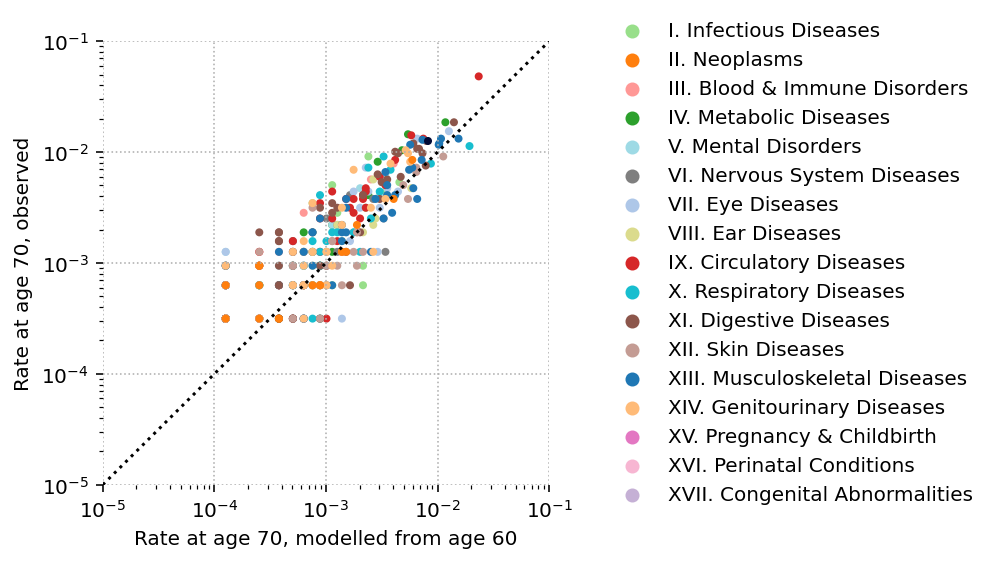

In [22]:
chapter_order = ['Technical', 'Sex', 'Smoking, Alcohol and BMI',
       'I. Infectious Diseases', 'II. Neoplasms', 'III. Blood & Immune Disorders',
       'IV. Metabolic Diseases', 'V. Mental Disorders',
       'VI. Nervous System Diseases', 'VII. Eye Diseases',
       'VIII. Ear Diseases', 'IX. Circulatory Diseases',
       'X. Respiratory Diseases', 'XI. Digestive Diseases',
       'XII. Skin Diseases', 'XIII. Musculoskeletal Diseases',
       'XIV. Genitourinary Diseases', 'XV. Pregnancy & Childbirth',
       'XVI. Perinatal Conditions', 'XVII. Congenital Abnormalities', 'Death']

a = 70
plt.figure(figsize=(4,4))
plt.scatter(syn_inc[:,a], real_inc[:,a], marker=".", c=delphi_labels['color'])
plt.xlabel(f'Rate at age {a}, modelled from age {age}')
plt.ylabel(f'Rate at age {a}, observed')
plt.yscale('log')
plt.xscale('log')
plt.plot([0,1],[0,1], transform=plt.gca().transAxes, c='k', ls=":")
plt.xlim(1e-5,.1)
plt.ylim(1e-5,.1)

for chapter in chapter_order[3:-1]:
    color = delphi_labels[delphi_labels['ICD-10 Chapter (short)'] == chapter]['color'].values[0]
    plt.scatter([], [], c=color, label=chapter)

plt.legend(loc='center left', bbox_to_anchor=(1.1, 0.5), frameon=False)
plt.show()

Text(0, 0.5, 'Time to next token')

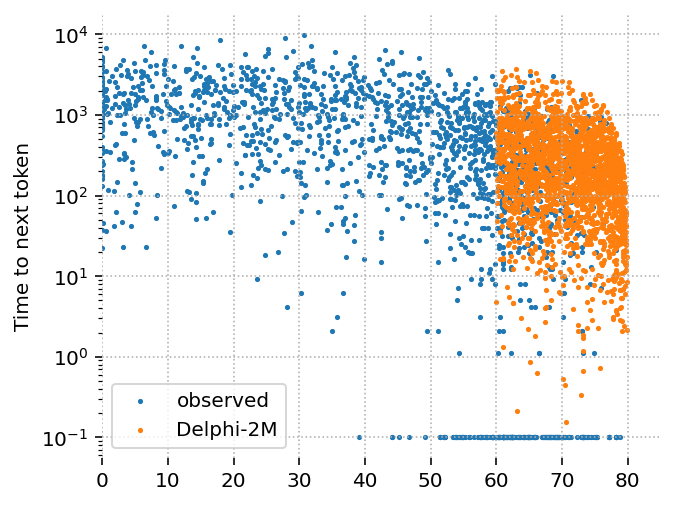

In [23]:
plt.figure(figsize=(5,4))

plt.scatter(d[1][u[:64]].cpu()[:,:-1].flatten()/365.25, .1+np.diff(d[1][u[:64]].cpu().detach(), axis=1).flatten(), marker='.', s=10, label='observed')

plt.scatter(oo[0][1].cpu()[:,48:-1].flatten()/365.25, np.diff(oo[0][1][:,48:].cpu().detach(), axis=1).flatten(), marker='.', s=10, label='Delphi-2M')
plt.yscale('log')
plt.legend()
plt.xlim(0,85)
plt.ylabel('Time to next token')

### Whole validation cohort

In [24]:
from tqdm import tqdm

In [25]:
def aggregate(x, t, start, end):
    t = t.clamp(start, end)
    use = ((t >= start) * (t<end))+0.
    dt = t.diff(1)
    return torch.einsum("ijk,ij->ik", (x.nan_to_num() * use[:,:-1,None]), dt)

In [26]:
d = get_batch(range(0,val_p2i.shape[0]-1,1), val, val_p2i,  
              select='smart_random', block_size=64, 
              device=device, padding='random')

In [27]:
age_sample = 60
n_samples = 1024 * 4

w = np.where((d[1].cpu().detach().numpy() <= age_sample * 365.25) * (d[3].cpu().detach().numpy() >= age_sample * 365.25))
#v = np.where(torch.isin(d[0].cpu(), torch.tensor(diseases_of_interest)).numpy())
u = np.unique(w[0])
#u = np.array(sorted(list(set(v[0]) & set(w[0]))))
n_samples = len(u)
# n_samples = 512 * 8

d0 = d[0][u[:n_samples]].clone().detach()
d1 = d[1][u[:n_samples]].clone().detach()

d0[d1>age_sample*365.25] = 0
d1[d1>age_sample*365.25] = -10000.

if age_sample > 0:
    d0 = torch.nn.functional.pad(d0, (0,1), 'constant', 1)
    d1 = torch.nn.functional.pad(d1, (0,1), 'constant', age_sample*365.25)

o = d1.argsort(1)
d0 = d0.gather(1, o)[:,-48:]
d1 = d1.gather(1, o)[:,-48:]

In [28]:
batch_size = 256
ooo = []
iinc = []
model.to(device)

with torch.no_grad():
    for rep in range(1):
        oo = []
        inc = []
        for dd in tqdm(zip(*map(lambda x: torch.split(x, batch_size), (d0,d1))), total=n_samples//batch_size + 1):
            mm = model.generate(dd[0].to(device), dd[1].to(device), max_age=80*365.25, no_repeat=True)
            oo += [(mm[0].cpu(),mm[1].cpu())]
            inc += [torch.stack([aggregate(mm[2][:,:-1].exp(), mm[1].nan_to_num(80 * 365.25), a * 365.25, (a+1)* 365.25)/\
                                 aggregate(~mm[2][:,:-1].isnan(), mm[1].nan_to_num(80 * 365.25), a * 365.25, (a+1)* 365.25) for a in range(40, 80)], dim=2).cpu()]
        ooo += [oo]
        iinc += [inc]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 249/249 [07:43<00:00,  1.86s/it]


In [29]:
inc = torch.stack([torch.vstack([i for i in inc]) for inc in iinc])[0].transpose(1,2) #.median(0).values
inc *= 365.25
n_samples = inc.shape[0]

In [30]:
def comp_at_risk(idx, age, size=1270):
    fill = idx + 0
    fill[fill == 1] = 0
    logits = torch.ones((idx.shape[0], idx.shape[1], size))
    logits = torch.stack([logits[:,j].scatter_(1, fill[:,:j+1], 0.0) for j in range(fill.shape[1])]).transpose(0,1)
    return logits

In [31]:
def agg_inc(d0, d1, pad=2.5, normalize="lof"):
    k = d0
    j = (d1/365.25).nan_to_num(-27).int()
    inc = torch.histogramdd(torch.stack([j.flatten(), k.flatten()], dim=1).float(), bins=[torch.arange(101).float(), torch.arange(1271).float()]).hist
    N = inc.sum(1)
    if normalize=="lof":
        inc /= (d0.shape[0] - torch.histogram((d1/365.25).max(1).values+pad, bins=torch.arange(0,101).float()).hist.cumsum(0)[:,None])
    elif normalize=="death":
        inc /= (d0.shape[0] - inc[:,-1].cumsum(0)[:,None])
    return inc, N

In [32]:
inc_sim = torch.stack([agg_inc(*x, normalize=False)[0] for x in oo]).sum(0)
inc_sim /= (n_samples - inc_sim[:,-1].cumsum(0)[:,None])

In [33]:
d_obs = (d[2][u[:n_samples]].cpu(),d[3][u[:n_samples]].cpu())
l_max = max([x[0].shape[1] for x in ooo[0]])

d_sim = (torch.vstack([torch.zeros([x[0].shape[0], l_max]).slice_scatter(x[0], dim=1, start=l_max-x[0].shape[1]).int() for x in ooo[0]]),
         torch.vstack([torch.zeros([x[1].shape[0], l_max]).slice_scatter(x[1], dim=1, start=l_max-x[1].shape[1]) for x in ooo[0]]))

N = agg_inc(*d_sim)[1]

In [34]:
inc_obs = agg_inc(*d_obs, pad=3.)[0]
inc_sim = agg_inc(*d_sim, normalize='death')[0]
#inc_obs /= (n_samples - torch.histogram((d_obs[1]/365.25).max(1).values+2.5, bins=torch.arange(0,101).float()).hist.cumsum(0)[:,None])

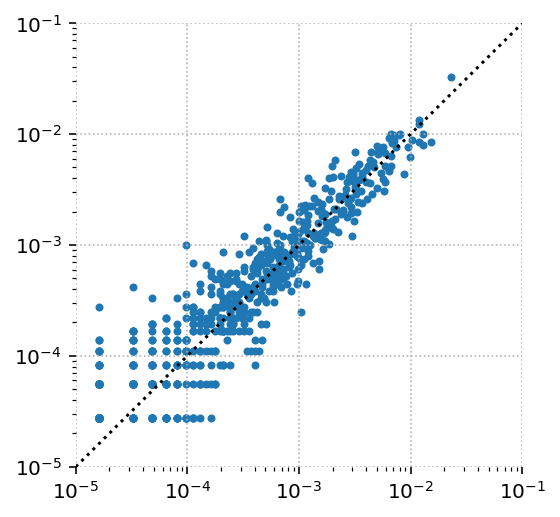

In [35]:
plt.figure(figsize=(4,4))
plt.scatter(inc_sim[70,13:],inc_obs[70,13:], marker='.')
plt.yscale('log')
plt.xscale('log')
plt.xlim(1e-5,1e-1)
plt.ylim(1e-5,1e-1)
plt.plot([0,1],[0,1], transform=plt.gca().transAxes, c='k', ls=":")

In [36]:
# time_obs = d_obs[1][w,-1]/365.25-60
# is_male = (d[0][u].cpu()==3).sum(1)>0
# m_obs  = (agg_inc(d_obs[0][w].cpu(), d_obs[1][w].cpu(), normalize='death')[0][39:79,13:] > 0).sum(1)

In [37]:
diseases_of_interest = [np.where(labels[0].str.startswith(x))[0][0] for x in ['A41','B01','C25','C50','G30','E11','F32','I21','J45','Death',]] #M19

In [45]:
d_ = d0.cpu()
t_sim =  [set(np.where(inc[i,-1].isnan())[0]) - set(d_[i].cpu().numpy())  for i in range(inc.shape[0])]

In [ ]:
n_sim = inc[:,10:,13:].isnan().sum(-1)
#n_sim = np.array([len(x) for x in t_sim])

age_sample = 60
n_obsyears = (d_obs[1][:,-1]/365.25).ceil().long().clamp(max=79) - age_sample

n_sim = n_sim.take_along_dim(n_obsyears[:,None], 1).squeeze()
t_obs = [set(d_obs[0][i][(d_obs[1][i] > age_sample*365.25) * (d_obs[1][i] < 80*365.25) * (d_obs[0][i] > 12)].numpy())  for i in range(inc.shape[0])]
n_obs = ((d_obs[1] > age_sample * 365.25) * (d_obs[1] < 80 * 365.25) * (d_obs[0] > 12)).sum(-1)

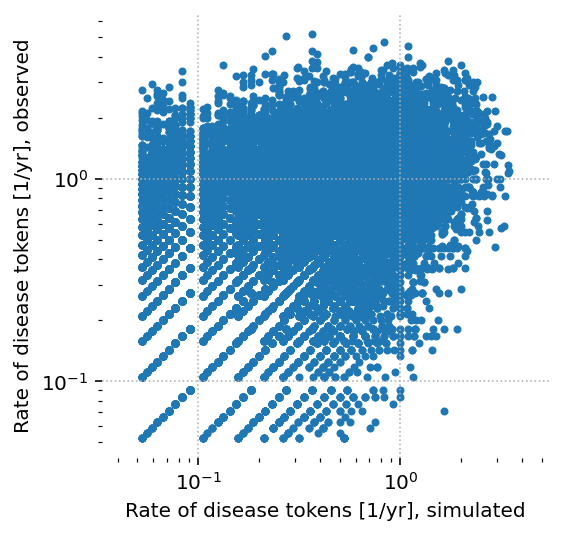

In [51]:
plt.figure(figsize=(4,4))
plt.gca().axis('equal')
plt.scatter((n_sim/n_obsyears)[n_obsyears>10], (n_obs/n_obsyears)[n_obsyears>10], marker=".")
plt.xlabel('Rate of disease tokens [1/yr], simulated')
plt.ylabel('Rate of disease tokens [1/yr], observed')
plt.yscale('log')
plt.xscale('log')

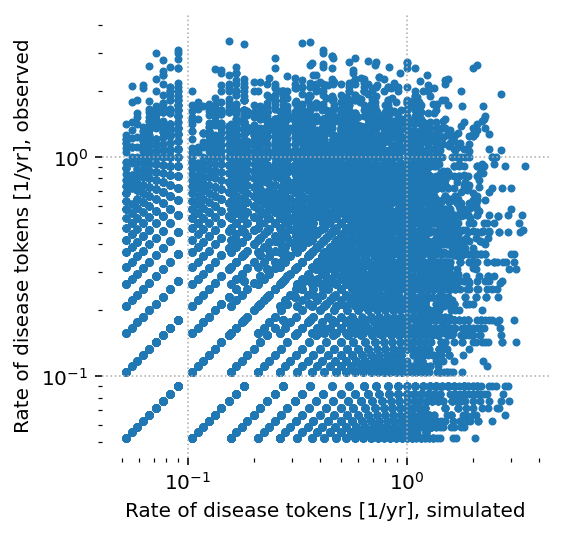

In [52]:
plt.figure(figsize=(4,4))
plt.gca().axis('equal')
plt.scatter((n_sim/n_obsyears)[n_obsyears>10], (n_sim.flip(0)/n_obsyears)[n_obsyears>10], marker=".")
plt.xlabel('Rate of disease tokens [1/yr], simulated')
plt.ylabel('Rate of disease tokens [1/yr], observed')
plt.yscale('log')
plt.xscale('log')

In [53]:
n_sim_obs = np.array([len(t_obs[i] & t_sim[i]) for i in range(inc.shape[0])])

In [54]:
p = np.arange(len(t_sim))
p[np.where((d0[:n_samples].cpu() == 2).any(1))[0]] = p[np.where((d0[:n_samples].cpu() == 2).any(1))[0]][::-1]
p[np.where((d0[:n_samples].cpu() == 3).any(1))[0]] = p[np.where((d0[:n_samples].cpu() == 3).any(1))[0]][::-1]
p[np.where(~(d0[:n_samples].cpu() == 2).any(1) * ~(d0[:n_samples].cpu() == 3).any(1))[0]] = p[np.where(~(d0[:n_samples].cpu() == 2).any(1) * ~(d0[:n_samples].cpu() == 3).any(1))[0]][::-1]

#np.concatenate([np.where((d0.cpu() == 2).any(1))[0][::-1], np.where((d0.cpu() == 3).any(1))[0][::-1]

In [55]:
n_sim_obs_perm = np.array([len(t_obs[i] & t_sim[p[i]]) for i in range(inc.shape[0])])

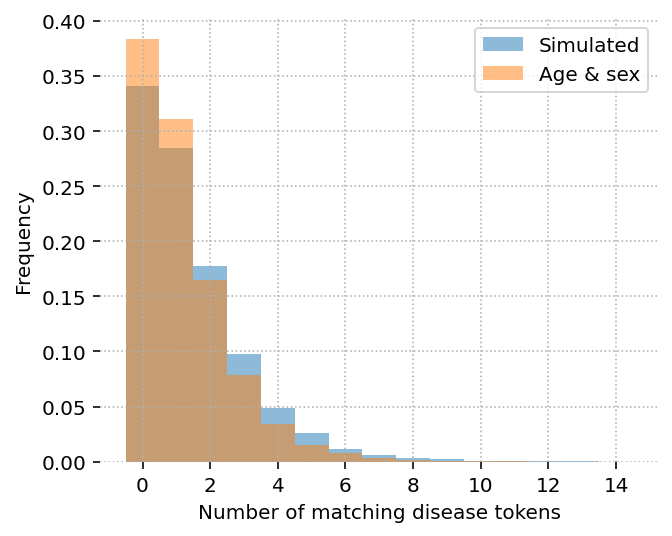

In [56]:
plt.figure(figsize=(5,4))
h0 = plt.hist(n_sim_obs[n_obsyears > 10 ], bins=np.arange(-.5,15), alpha=0.5, label='Simulated', density=True)
h1 = plt.hist(n_sim_obs_perm[n_obsyears > 10], bins=np.arange(-.5,15), alpha=0.5, label='Age & sex', density=True)
plt.xlabel('Number of matching disease tokens')
plt.ylabel('Frequency')
plt.legend()

In [57]:
batch_size = 128
max_iters = float("Inf")
n_rep = 1
lll = []
model.to(device)
ooo = []
with torch.no_grad():
    for i,dd in tqdm(enumerate(zip(*map(lambda x: torch.split(x, batch_size), (d0,d1, d[1][u[:n_samples]].cpu())))), position=0,  total=n_samples//batch_size + 1):
        if i >= max_iters: 
            break
        oo = []
        for rep in range(n_rep):
            idx, age, logits = model.generate(dd[0].to(device), dd[1].to(device), max_age=80*365.25, no_repeat=True)
            oo += [(idx.cpu(),age.cpu())]
        ooo += [oo]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 498/498 [06:47<00:00,  1.22it/s]


In [58]:
dd_sim = []
for rep in tqdm(range(n_rep)): 
    l_max = max([x[rep][0].shape[1] for x in ooo])
    
    d_sim = (torch.vstack([torch.zeros([x[rep][0].shape[0], l_max]).slice_scatter(x[rep][0], dim=1, start=l_max-x[rep][0].shape[1]).int() for x in ooo]),
             torch.vstack([torch.zeros([x[rep][1].shape[0], l_max]).slice_scatter(x[rep][1], dim=1, start=l_max-x[rep][1].shape[1]) for x in ooo]))
    dd_sim += [d_sim]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 26.47it/s]


In [73]:
batch_size=128
inc = []
with torch.no_grad():
    for i,dd in tqdm(enumerate(zip(*map(lambda x: torch.split(x, batch_size), (d0,d1)))), position=0,  total=n_samples//batch_size + 1):
        logits, _, _ = model(dd[0].to(device),dd[1].to(device))
        inc += [logits[:,-2:,:].cpu()]
inc = torch.vstack(inc)

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 498/498 [00:05<00:00, 83.33it/s]


In [74]:
inc = 1-(-inc.exp()*365.25).exp()

In [78]:
n_sim_obs = []
n_sim_obs_perm = []
for d_sim in dd_sim:
    t_sim = [set(d_sim[0][i][(d_sim[1][i] > age_sample*365.25) * (d_sim[1][i] < 80*365.25) * (d_sim[0][i] > 12)].numpy())  for i in range(inc.shape[0])]
    n_sim = ((d_sim[1] > age_sample * 365.25) * (d_sim[1] < 80 * 365.25) * (d_sim[0] > 12)).sum(-1)
    n_sim_obs += [np.array([len(t_obs[i] & t_sim[i]) for i in range(inc.shape[0])])]
    n_sim_obs_perm += [np.array([len(t_obs[i] & t_sim[p[i]]) for i in range(inc.shape[0])])]
n_sim_obs = np.array(n_sim_obs)
n_sim_obs_perm = np.array(n_sim_obs_perm)

/tmp/ipykernel_8162/3291688939.py:3: RuntimeWarning: invalid value encountered in divide
  plt.plot([np.nanmean(n_sim_obs[:,n_obsyears==x].mean(0)/n_obs[n_obsyears==x].numpy())  for x in range(20)], label='Delphi-2M', ds='steps', c='C1')
/tmp/ipykernel_8162/3291688939.py:3: RuntimeWarning: Mean of empty slice
  plt.plot([np.nanmean(n_sim_obs[:,n_obsyears==x].mean(0)/n_obs[n_obsyears==x].numpy())  for x in range(20)], label='Delphi-2M', ds='steps', c='C1')
/tmp/ipykernel_8162/3291688939.py:4: RuntimeWarning: invalid value encountered in divide
  plt.plot([np.nanmean(n_sim_obs_perm[:,n_obsyears==x].mean(0)/n_obs[n_obsyears==x].numpy())  for x in range(20)], label='Age and sex', ds='steps', c='C0')
/tmp/ipykernel_8162/3291688939.py:4: RuntimeWarning: Mean of empty slice
  plt.plot([np.nanmean(n_sim_obs_perm[:,n_obsyears==x].mean(0)/n_obs[n_obsyears==x].numpy())  for x in range(20)], label='Age and sex', ds='steps', c='C0')


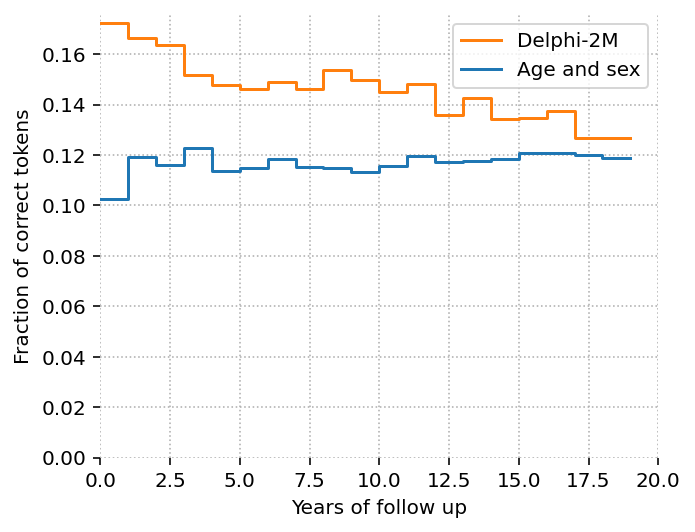

In [79]:
plt.figure(figsize=(5,4))

plt.plot([np.nanmean(n_sim_obs[:,n_obsyears==x].mean(0)/n_obs[n_obsyears==x].numpy())  for x in range(20)], label='Delphi-2M', ds='steps', c='C1')
plt.plot([np.nanmean(n_sim_obs_perm[:,n_obsyears==x].mean(0)/n_obs[n_obsyears==x].numpy())  for x in range(20)], label='Age and sex', ds='steps', c='C0')
plt.xlim(0,20)
plt.xlabel('Years of follow up')
plt.ylabel('Fraction of correct tokens')
plt.ylim(0,None)
plt.legend()

### Multiple replicates

In [80]:
def get_surv(d, k):
    w = d[0]==k
    x,y = (d[0]==k)[w], d[1][w]
    v = w.int().sum(1)==0
    return  torch.concat([x,torch.zeros(v.sum()).bool()]).numpy(), torch.concat([y, d[1][v,-1]]).numpy()

In [81]:
diseases_of_interest

[46, 95, 1168, 1188, 374, 215, 305, 505, 603, 1269]

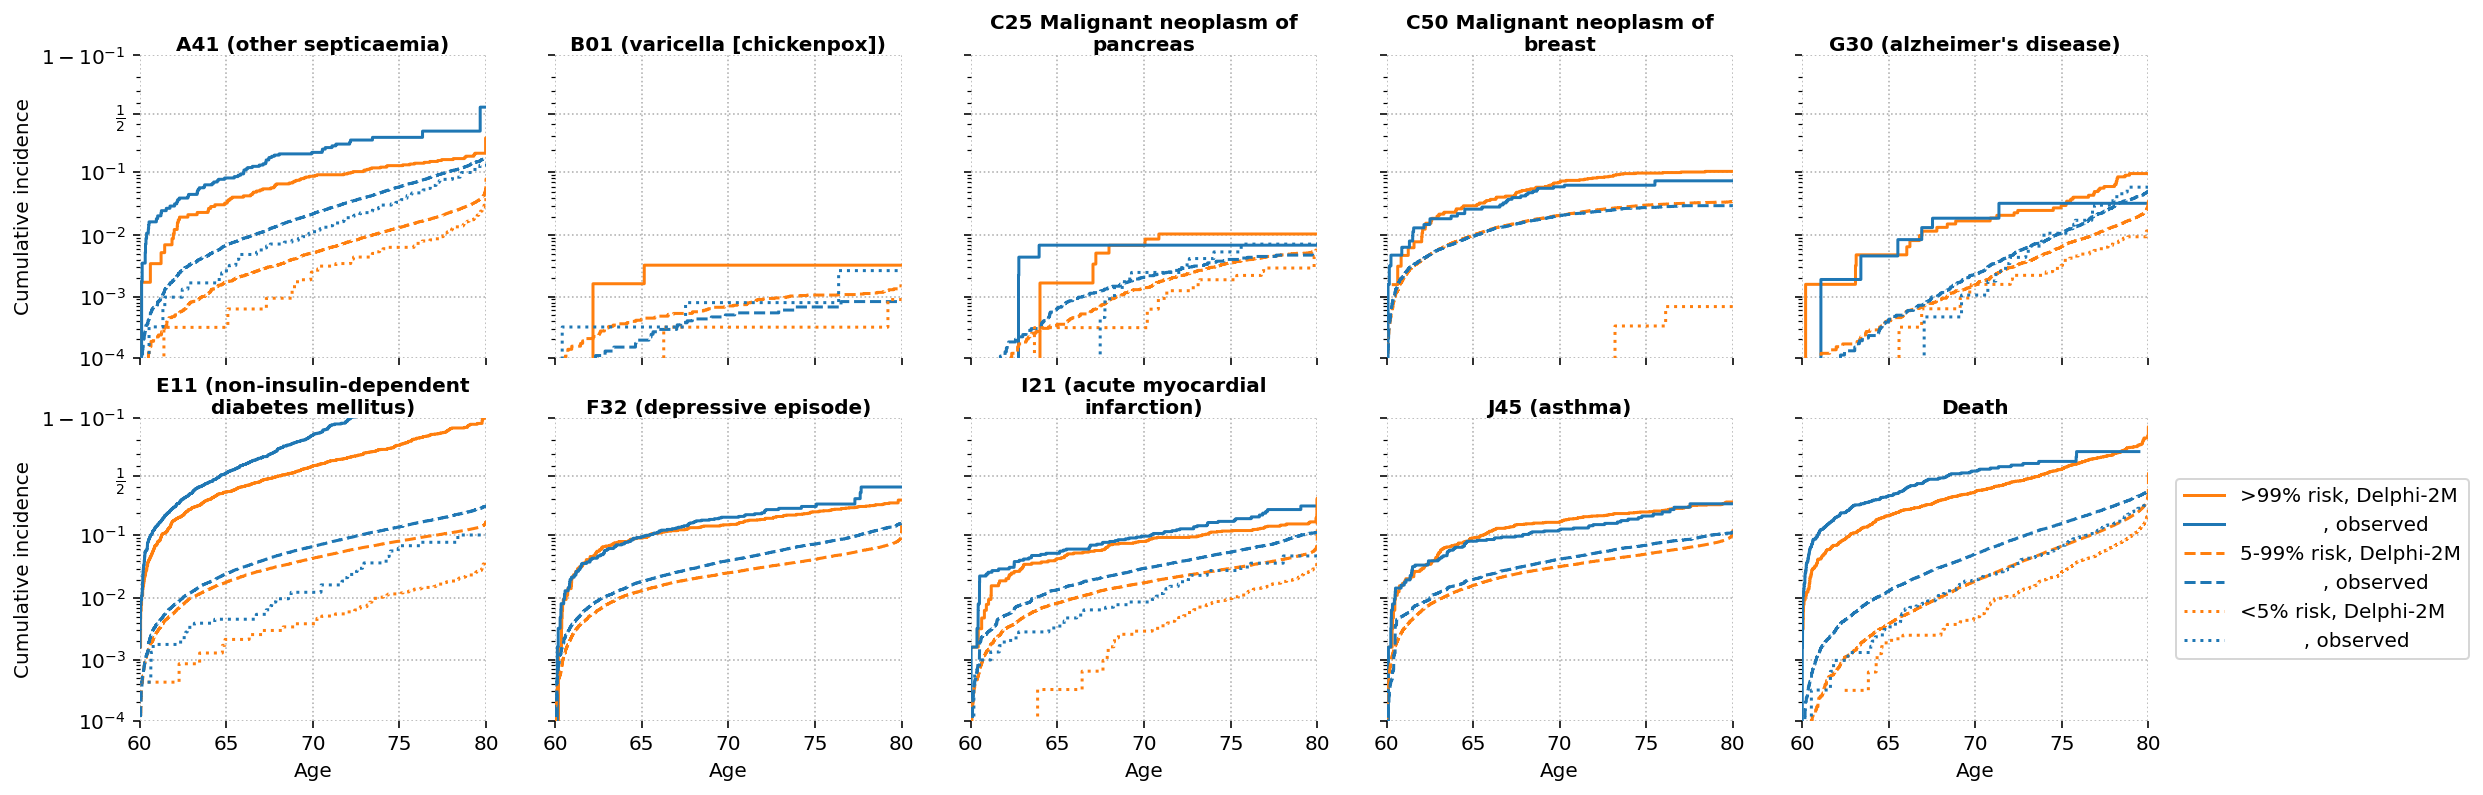

In [83]:
import sksurv
import sksurv.nonparametric
import textwrap

fig, ax = plt.subplots((len(diseases_of_interest)-1)//5+1,5, figsize=(18,(3*(len(diseases_of_interest)-1)//5+1)), sharex=True, sharey=True)
for l,k in enumerate(diseases_of_interest):# 1168# 1269
    axf = ax.ravel()
    for g in range(3):
        if g == 2:
            w = inc[:,-1,k] <= torch.quantile(inc[:,-1,k].nan_to_num(), 0.05)
        elif g == 1:
            w = (inc[:,-1,k] > torch.quantile(inc[:,-1,k].nan_to_num(), 0.05)) * (inc[:,-1,k] <= torch.quantile(inc[:,-1,k].nan_to_num(), 0.99))
        else:
            w = inc[:,-1,k] > torch.quantile(inc[:,-1,k].nan_to_num(), 0.99)
        w *= ~((d_obs[0] == k) * (d_obs[1]/365.25 < 60)).any(1)
        w.sum()

        r = -(1-inc[w,-1,k]).log()/365.25
        c = 1-(-r.mean()*torch.arange(20*365.25)).exp()

        def cuminc(x):
            return x[0], 1-x[1] + 1e-6

        d_sim = torch.vstack([x[0][w][:,:114] for x in dd_sim]), torch.vstack([x[1][w][:,:114].nan_to_num(-10000.)/365.25 for x in dd_sim])
        o = d_sim[1].argsort(1)
        d_sim = d_sim[0].gather(1,o), d_sim[1].gather(1,o)
        
        try:
            axf[l].plot(*cuminc(sksurv.nonparametric.kaplan_meier_estimator(*get_surv(d_sim, k))), label=f'{[">99%","5-99%","<5%"][g]} risk, Delphi-2M',  ls=["-","--",":"][g], c="C1", ds='steps-post') #c=['C3','C7','C0']
        except:
            pass
        
        if (d_obs[0][w]==k).sum() < 1:
            continue
        
        try:
            axf[l].plot(*cuminc(sksurv.nonparametric.kaplan_meier_estimator(*get_surv((d_obs[0][w],d_obs[1][w]/365.25), k))), label=f'{["             ","             ","          "][g]}, observed',  ls=["-","--",":"][g], c="C0" ,ds='steps-post')
        except:
            pass

        #plt.plot(torch.arange(20*365.25)/365.25+60, c, c="C2", ls=[":","--","-"][g])
    axf[l].set_xlim(60,80)
    axf[l].set_ylim(1e-4,0.9)
    axf[l].set_yscale('logit')
    if l % ax.shape[1] ==0:
        axf[l].set_ylabel('Cumulative incidence')

    if l // ax.shape[1] == ax.shape[0] -1:
        axf[l].set_xlabel('Age')

    if l == len(diseases_of_interest)-1:
        axf[l].legend(loc='center left', bbox_to_anchor=(1.05, 0.5))        
    axf[l].set_title("\n".join(textwrap.wrap(labels.iloc[k,0], width=30)), verticalalignment='top', fontsize=10, fontweight='bold')